# Running the DiuSST model and plotting results

Date: 20 Mar 2022

This tutorial provides a complete example of running the DiuSST model using real atmospheric forcing data.

First, we need to load the required standard modules (numpy, matplotlib, pandas) as well as the custom modules containing the code for DiuSST.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Access source code
import sys
sys.path.append('../src')

# Load DiuSST model
from diusst import Diusst

## Step 1: Load atmospheric dataset

Let's load the MOCE-5 dataset contained in the `input_data` directory and store it as a pandas DataFrame. As we see from the output, it contains atmospheric data such as wind speed (`wind`) and shortwave radiation (`swrad`) which we will use to force the model.

In [2]:
data_path = '../input_data/moce5/'
data_filename = 'training_moce5_err-boatspd-x2_humid10.csv'

data_orig = pd.read_csv(data_path+data_filename)
data_orig

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid,boatspd
0,31625.760,291.797,0.147397,291.538,0.947,290.451,695.5,0.01,12.3
1,32321.472,292.099,0.085068,291.222,1.015,290.947,635.6,0.01,12.4
2,33008.616,292.336,0.147397,291.748,1.167,290.868,559.7,0.01,12.3
3,35765.736,293.311,0.063959,290.777,1.739,291.826,737.2,0.01,1.5
4,36452.880,291.097,0.070329,291.185,2.471,291.596,774.3,0.01,0.5
...,...,...,...,...,...,...,...,...,...
1847,1736233.800,291.047,0.233219,291.618,1.458,291.480,0.5,0.01,8.1
1848,1736879.760,290.679,0.107123,291.191,1.189,291.589,0.5,0.01,8.4
1849,1737525.360,290.740,0.106192,291.205,0.435,291.640,0.6,0.01,8.2
1850,1738171.200,290.996,0.087068,291.312,0.900,291.616,0.6,0.01,8.1


## Step 2: Specify model settings

In the next cell, we specify all the parameters and other options for the simulation.

In [11]:
# Foundation temperature
T_f = np.mean(data_orig['ftemp'].to_numpy())

# Key parameters
kappa = 1.799e-4         # Eddy diffusivity
mu = 0.002576            # Mixing coefficient
alpha = 2.445            # Attenuation coefficient
sigma = 0.8              # Surface suppressivity

# Options
diffu_profile = 'LIN'    # Diffusivity profile
CFL = 0.95               # CFL number for integration

# Domain
z_f = 10                 # Foundation depth
dz0 = 0.1                # Grid spacing at surface
ngrid = 40               # Number of vertical grid points

print('Foundation temperature: {:.2f} K'.format(T_f))

Foundation temperature: 298.19 K


## Step 3: Create model instance

Now we call the `Diusst` class, which creates a model instance (called `model`) with the specified settings.

In [12]:
model = Diusst(T_f=T_f, kappa=kappa, mu=mu, alpha=alpha, sigma=sigma,
                diffu_profile=diffu_profile, CFL=CFL, z_f=z_f, dz0=dz0, ngrid=ngrid)

## Step 4: Interpolate original data

The original dataset has a time intervals of several minutes. If we would input this time series directly into the model, the simulation would become instable because the CFL condition will not be met. Therefore, we must interpolate the dataset such that the time step between adjacent data points is small enough to satisfy the CFL condition. For this purpose, the `Diusst` class features the `interpolate` function which we call below. It adapts the time step to the current wind conditions in order to save computation time while maintaining a constant CFL number as specified above.

The `interpolate` function returns a list of 1) the interpolated DataFrame, 2) an array of time steps for the interpolated data, and 3) an array of indices in the interpolated dataset corresponding to the original data points.

In [13]:
data_intp, dtlist, idx = model.interpolate(data_orig)

Variable time-step interpolation at CFL = 0.95:
---> Interpolated dataset has 336516 time steps with average length 6.935 s.
---> Constant dt interpolation would require dt = 1.274 s --> 1339815 steps.
---> Computation time will be reduced by 74.883 %.


## Step 5: Run the model

We are ready to run diuSST! This works by calling the `simulate` function.

In [14]:
simu = model.simulate(data_intp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336515/336515 [00:25<00:00, 13449.82it/s]


The dataset provides the temperature difference between the sea skin (`sst`) and the water temperature at 3m depth (`ftemp`). Therefore, to compare our simulation with the observational data, we must find the grid point closest to 3m depth and take the temperature difference with respect to that grid point.

In [17]:
# Grid point closest to 3m depth
ref_level = int(20)

# Calculate temperature difference
simu_sst = simu[0][:,0]-simu[0][:,ref_level]

print('Reference depth at which the SST difference is taken: {} m.'.format(round(simu[2][ref_level],2)))

Reference depth at which the SST difference is taken: -3.05 m.


## Plot results

Finally, let us plot the results of our simulation.

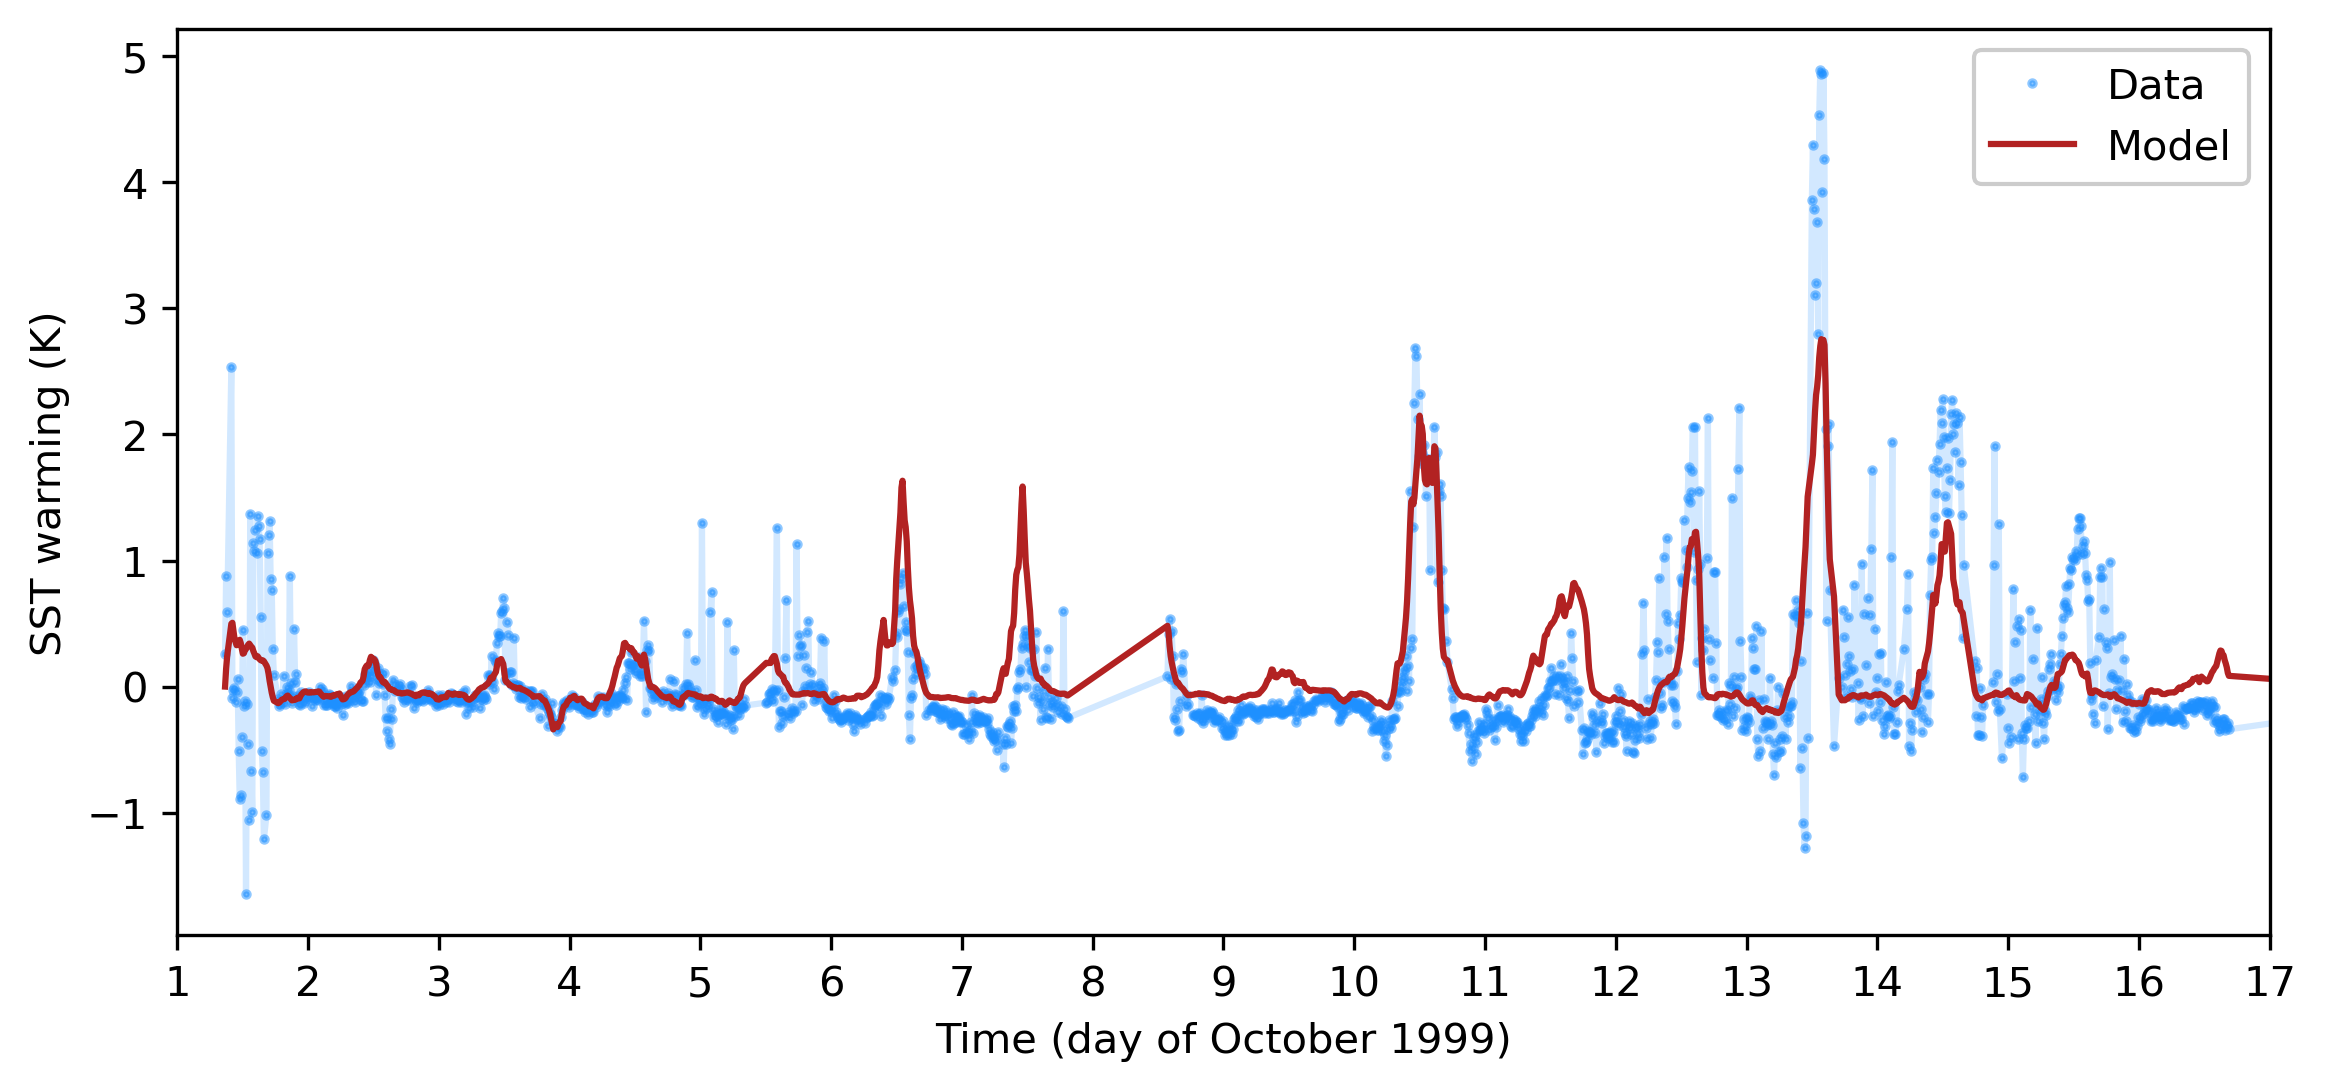

In [18]:
fig, ax = plt.subplots(dpi=300,figsize=(9,4))

ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],alpha=0.2,c='dodgerblue')
ax.plot(data_orig['times']/86400,data_orig['sst']-data_orig['ftemp'],'.',markersize=3,alpha=0.5,c='dodgerblue', label='Data')
ax.plot(data_orig['times'][:-1]/86400,simu_sst[idx],c='firebrick', label='Model')

ax.legend(framealpha=1)
ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set_xlim(0,16)
ax.set(xlabel='Time (day of October 1999)')
ax.set(ylabel='SST warming (K)')

plt.show()

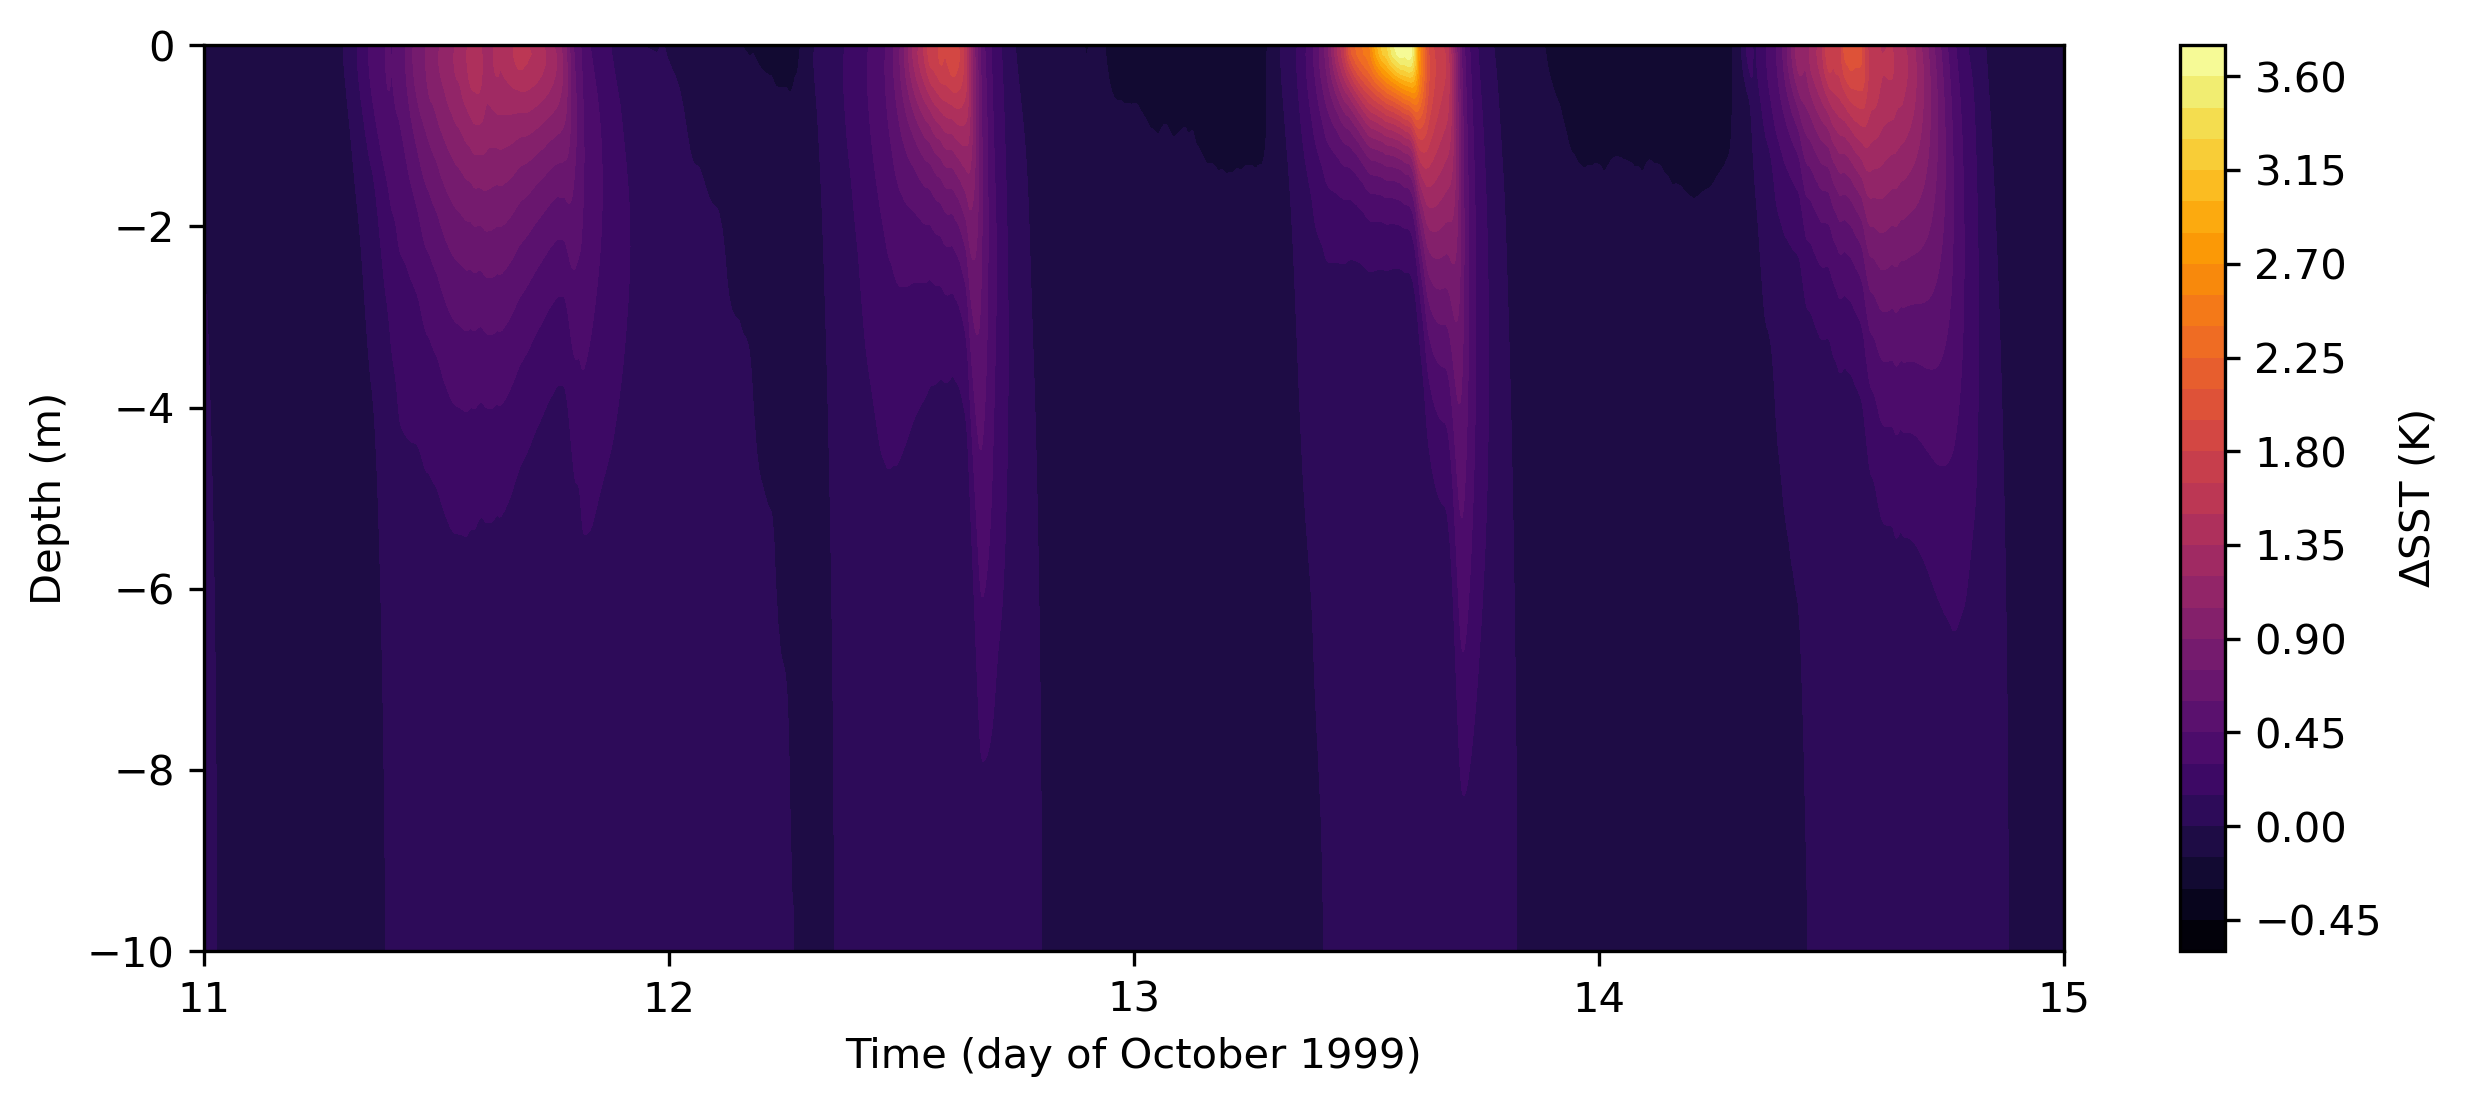

In [8]:
fig, ax = plt.subplots(dpi=300,figsize=(10,4))
plot = ax.contourf(simu[1]/86400,simu[2],simu[0].transpose()-T_f,levels=30,cmap='inferno')

ax.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax.set(xlabel='Time (day of October 1999)', ylabel='Depth (m)')
ax.set(ylim=(-10,0), xlim=(10,14))
plt.colorbar(plot,label='$\Delta$SST (K)')

plt.show()

That's it!